<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Optimization-params" data-toc-modified-id="Optimization-params-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Optimization params</a></span></li><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Benchmark</a></span></li><li><span><a href="#Time-Forest" data-toc-modified-id="Time-Forest-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Time Forest</a></span></li><li><span><a href="#Simplified-benchmark" data-toc-modified-id="Simplified-benchmark-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Simplified benchmark</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plots</a></span></li></ul></div>

# GE News - Time Forest Vs Random Forest

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pdb
import warnings
import seaborn as sns

from sklearn import metrics
from time import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss, f1_score, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from time_robust_forest.models import TimeForestClassifier
from time_robust_forest.functions import check_categoricals_match, check_numerical_match
from time_robust_forest.hyper_opt import env_wise_hyper_opt
from aux_functions import *

warnings.filterwarnings('ignore')

/home/jovyan/.conda/envs/msc-2/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [3]:
set_style()

In [129]:
PREFIX = "ge_news"

In [4]:
STOP_WORDS = ['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'é', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'foi', 'ao', 'ele', 'das', 'tem', 'à', 'seu', 'sua', 'ou', 'ser', 'quando', 'muito', 'há', 'nos', 'já', 'está', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'era', 'depois', 'sem', 'mesmo', 'aos', 'ter', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'estão', 'você', 'tinha', 'foram', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'têm', 'numa', 'pelos', 'elas', 'havia', 'seja', 'qual', 'será', 'nós', 'tenho', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'fosse', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estivermos', 'estiverem', 'hei', 'há', 'havemos', 'hão', 'houve', 'houvemos', 'houveram', 'houvera', 'houvéramos', 'haja', 'hajamos', 'hajam', 'houvesse', 'houvéssemos', 'houvessem', 'houver', 'houvermos', 'houverem', 'houverei', 'houverá', 'houveremos', 'houverão', 'houveria', 'houveríamos', 'houveriam', 'sou', 'somos', 'são', 'era', 'éramos', 'eram', 'fui', 'foi', 'fomos', 'foram', 'fora', 'fôramos', 'seja', 'sejamos', 'sejam', 'fosse', 'fôssemos', 'fossem', 'for', 'formos', 'forem', 'serei', 'será', 'seremos', 'serão', 'seria', 'seríamos', 'seriam', 'tenho', 'tem', 'temos', 'tém', 'tinha', 'tínhamos', 'tinham', 'tive', 'teve', 'tivemos', 'tiveram', 'tivera', 'tivéramos', 'tenha', 'tenhamos', 'tenham', 'tivesse', 'tivéssemos', 'tivessem', 'tiver', 'tivermos', 'tiverem', 'terei', 'terá', 'teremos', 'terão', 'teria', 'teríamos', 'teriam']
CLUB_WORDS = ["verdão", "tricolor", "fla", "timão", "rubro", 
              "negro", "flamengo", "paulo", "palmeirense", "paulista", 
              "inter", "colorado", "internacional", "colorados", "colorada"]
STOP_WORDS += CLUB_WORDS
MAX_VOCABULARY = 300
positive_case = "flamengo"

In [5]:
data = pd.read_csv("~/Documents/datasets/ge_news/data/ge_news.csv", index_col=False)

In [6]:
data.shape

(158507, 6)

In [7]:
data = data.sample(frac=0.5)

In [8]:
data.tail()

,date,time,title,text,link,club
123752,14/05/2017,08h24,Santos recebe Taubaté e mira assumir liderança...,+ Fique por dentro do esporte no Vale do Para...,https://globoesporte.globo.com/sp/vale-do-para...,santos
28391,28/06/2021,13h58,Bragantino oficializa contratação em definitiv...,O Red Bull Bragantino oficializou na tarde de...,https://ge.globo.com/sp/vale-do-paraiba-regiao...,bragantino
132211,14/05/2020,06h00,"Eleição de vitalícios, mudanças no estatuto e ...",A eleição para a presidência do São Paulo em ...,https://globoesporte.globo.com/futebol/times/s...,sao-paulo
142027,14/09/2020,17h40,"Com histórico de problemas fora de campo, Juni...","Aos 21 anos, ele teve a rescisão de contrato ...",https://globoesporte.globo.com/pe/futebol/noti...,sport
74632,05/12/2018,14h52,"CBF divulga ranking: Palmeiras lidera, e Cruze...",O ranking atribui pontos aos times dependendo...,https://globoesporte.globo.com/sp/futebol/noti...,fluminense


In [9]:
data.isna().sum()

date     0
time     0
title    0
text     0
link     0
club     0
dtype: int64

In [10]:
#data = data.sample(frac=0.2)
data.reset_index(drop=True, inplace=True)

In [11]:
def create_different_time_slices(data, time_col="date", aggregation="weekly", n_months=None):
    if aggregation == "daily": return data[time_col].dt.date
    if aggregation == "weekly": return data[time_col].dt.week
    if aggregation == "monthly": return data[time_col].apply(lambda x: x.strftime("%Y-%m"))
    if aggregation == "semester": return False


def exclude_periods_without_positive_case(data, positive_case, period_column, threshold=20):
    df = data.groupby(period_column)["club"].apply(lambda x: np.sum(x == positive_case))
    df = df[df > threshold]
    return data[data[period_column].isin(df.index)]
    
def clean_club_name_from_article(data):
    data["text"] = data.apply(lambda x: x["text"].lower().replace(x["club"].replace("-", " "), ""), axis=1)
    return data

def exclude_numbers(data):
    data["text"] = data["text"].apply(lambda x: ''.join([i for i in x.lower() if not i.isdigit()]))
    return data

def drop_multiple_teams_news(data):
    multiple_team_news = data.groupby("link", as_index=False)["club"].count()
    multiple_team_news = multiple_team_news[multiple_team_news["club"] > 1]["link"]
    return data[~data["link"].isin(multiple_team_news)]


In [12]:
data = clean_club_name_from_article(data)
data = exclude_numbers(data)
data = drop_multiple_teams_news(data)

In [13]:
data.loc[:, "year"] = data["date"].apply(lambda x: x.split("/")[-1])
data.loc[:, "month"] = data["date"].apply(lambda x: x.split("/")[1])
data.loc[:, "date"] = pd.to_datetime(data["date"])

In [14]:
### Monthly context
data["year-month"] = data["year"] + "-" + data["month"]

### Weekly context
data["year-week"] = create_different_time_slices(data)
data["year-week"] = data["year"] + "-" + data["year-week"].astype(str)

In [15]:
data["target"] = data["club"].apply(lambda x: 1 if x == positive_case else 0)

print("The fraction of positive cases is {:.2f}".format(data["target"].mean()))

The fraction of positive cases is 0.09


In [16]:
data = exclude_periods_without_positive_case(data, positive_case, "year-month")

In [17]:
train_end_date = "2019-01"
holdout_end_date = "2021-12"
train_end_year = int(train_end_date.split("-")[0])

In [18]:
in_time = data[data["year-month"] < train_end_date]

train, test = train_test_split(in_time, 
                               test_size=0.2, 
                               random_state=42)

out_of_time = data[(data["year-month"] >= train_end_date) & (data["year-month"] <= holdout_end_date)]

In [19]:
target = "target"
time_column = "year-month"
time_column = "year"
dummy_time_column = "dummy_date"

In [20]:
print("Dataset shapes:")
print("Train: {}".format(train.shape))
print("Test: {}".format(test.shape))
print("Out of time: {}".format(out_of_time.shape))

Dataset shapes:
Train: (17523, 11)
Test: (4381, 11)
Out of time: (40754, 11)


In [21]:
vectorizer = TfidfVectorizer(max_features=MAX_VOCABULARY,
                             stop_words=STOP_WORDS,
                             binary=False,
                             use_idf=True,
                             norm=False)

train_vectors = pd.DataFrame(vectorizer.fit_transform(train["text"]).toarray(), columns=vectorizer.vocabulary_)
test_vectors = pd.DataFrame(vectorizer.transform(test["text"]).toarray(), columns=vectorizer.vocabulary_)
oot_vectors = pd.DataFrame(vectorizer.transform(out_of_time["text"]).toarray(), columns=vectorizer.vocabulary_)

In [22]:
features = list(vectorizer.vocabulary_.keys())

In [23]:
train_vectors[time_column] = train[time_column].values
test_vectors[time_column] = test[time_column].values
oot_vectors[time_column] = out_of_time[time_column].values

In [24]:
train_vectors[dummy_time_column] = 1

In [25]:
train_vectors.reset_index(drop=True, inplace=True)
test_vectors.reset_index(drop=True, inplace=True)
oot_vectors.reset_index(drop=True, inplace=True)

In [63]:
model = RandomForestClassifier(max_depth=15, n_estimators=120)

In [64]:
model.fit(train_vectors.drop(columns=[time_column, dummy_time_column]), train["target"].values)

RandomForestClassifier(max_depth=15, n_estimators=120)

In [65]:
train["prediction"] = model.predict_proba(train_vectors.drop(columns=[time_column, dummy_time_column]))[:, 1]
roc_auc_score(train[target], train["prediction"])

0.9792794131962441

In [66]:
test["prediction"] = model.predict_proba(test_vectors.drop(columns=[time_column]))[:, 1]
roc_auc_score(test[target], test["prediction"])

0.875512286904079

In [67]:
out_of_time["prediction"] = model.predict_proba(oot_vectors.drop(columns=[time_column]))[:, 1]
roc_auc_score(out_of_time[target], out_of_time["prediction"])

0.7914893549302473

## Optimization params

In [31]:
# params_grid = {"n_estimators": [30], 
#               "max_depth": [5, 10, 15],
#               "min_impurity_decrease": [1e-3, 0],
#               "min_sample_periods": [1, 5, 10],
#               "period_criterion": ["max", "avg"]}

params_grid = {"n_estimators": [120], 
              "max_depth": [10, 15],
              "min_impurity_decrease": [0, 0.0001],
              "min_sample_periods": [1, 5, 10],
              "period_criterion": ["max", "avg"]}

params_grid_benchmark = params_grid.copy()
params_grid_benchmark.pop("period_criterion")

['max', 'avg']

## Benchmark

In [ ]:
model = TimeForestClassifier(time_column=dummy_time_column,
                                        multi=True)

benchmark_opt_param = env_wise_hyper_opt(train_vectors[features + [dummy_time_column]], 
                                         train[target].values, 
                                         model, 
                                         dummy_time_column, 
                                         params_grid_benchmark, 
                                         cv=5,
                                         scorer=make_scorer(roc_auc_score,
                                                  needs_proba=True))

benchmark_model = TimeForestClassifier(time_column=dummy_time_column,
                                       multi=True, 
                                       **benchmark_opt_param)

benchmark_model.fit(train_vectors[features + [dummy_time_column]], train[target])

In [39]:
benchmark_opt_param

{'max_depth': 15,
 'min_impurity_decrease': 0.0001,
 'min_sample_periods': 10,
 'n_estimators': 120}

In [104]:
importance = benchmark_model.feature_importance(impurity_decrease=True)
importance.rename(columns={"Importance": "Random Forest"}, inplace=True)
importance.head(20)

,Random Forest
Feature,
passou,0.624549
outro,0.527765
atleta,0.314020
elenco,0.304335
bastante,0.291996
santos,0.223510
futebol,0.177096
ficar,0.126689
feira,0.120198


In [ ]:
train["benchmark_prediction"] = benchmark_model.predict_proba(train_vectors[features])[:, 1]
test["benchmark_prediction"] = benchmark_model.predict_proba(test_vectors[features])[:, 1]
out_of_time["benchmark_prediction"] = benchmark_model.predict_proba(oot_vectors[features])[:, 1]

In [41]:
print(roc_auc_score(train[target], train["benchmark_prediction"]))
print(roc_auc_score(test[target], test["benchmark_prediction"]))
print(roc_auc_score(out_of_time[target], out_of_time["benchmark_prediction"]))

0.9271456542760106
0.8793298952066655
0.805530723450598


## Time Forest

In [ ]:
model = TimeForestClassifier(time_column=time_column,
                                        multi=True)

challenger_opt_param = env_wise_hyper_opt(train_vectors[features + [time_column]], 
                                         train[target].values, 
                                         model, 
                                         time_column, 
                                         params_grid, 
                                         cv=5,
                                         scorer=make_scorer(roc_auc_score,
                                                  needs_proba=True))

challenger_model = TimeForestClassifier(time_column=time_column,
                                       multi=True, 
                                       **challenger_opt_param)

challenger_model.fit(train_vectors[features + [time_column]], train[target])

In [91]:
challenger_opt_param

{'max_depth': 10,
 'min_impurity_decrease': 0.0001,
 'min_sample_periods': 1,
 'n_estimators': 120,
 'period_criterion': 'max'}

In [102]:
challenger_model.feature_importance(impurity_decrease=True).head(20)

,Importance
Feature,
passou,0.268158
elenco,0.106211
atleta,0.075270
bastante,0.060752
ficar,0.039413
competição,0.028519
afirmou,0.025432
anos,0.016717
libertadores,0.016335


In [121]:
challenger_importances = challenger_model.feature_importance(impurity_decrease=True).rename(columns={"Importance": "Time Robust Forest"})
all_importances = importance.merge(challenger_importances, left_index=True, right_index=True)

all_importances.head(30)

,Random Forest,Time Robust Forest
Feature,,
passou,0.624549,0.268158
outro,0.527765,0.007590
atleta,0.314020,0.075270
elenco,0.304335,0.106211
bastante,0.291996,0.060752
santos,0.223510,0.002033
futebol,0.177096,0.002953
ficar,0.126689,0.039413
feira,0.120198,0.003841


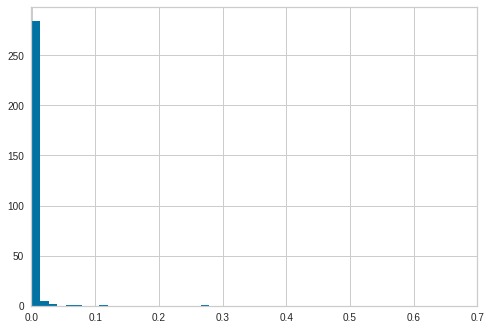

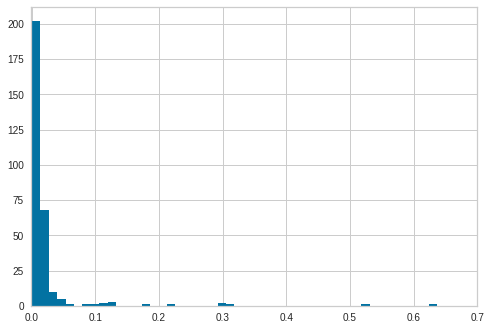

In [112]:
bins = np.linspace(0, 0.65)
plt.hist(challenger_model.feature_importance(impurity_decrease=True)["Importance"], bins=bins)
plt.xlim([-0.001, 0.70])
plt.show()
plt.hist(benchmark_model.feature_importance(impurity_decrease=True)["Importance"], bins=bins)
plt.xlim([-0.001, 0.70])
plt.show()

In [122]:
all_importances.corr()

,Random Forest,Time Robust Forest
Random Forest,1.000000,0.791173
Time Robust Forest,0.791173,1.000000


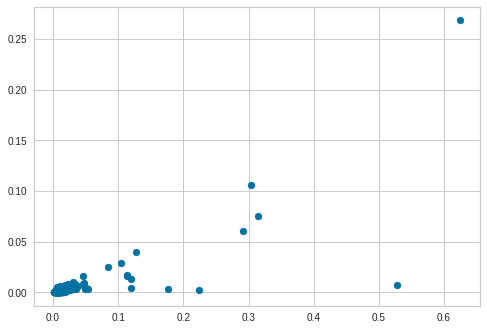

In [123]:
plt.scatter(all_importances["Random Forest"], all_importances["Time Robust Forest"])

In [ ]:
train["challenger_prediction"] = challenger_model.predict_proba(train_vectors[features])[:, 1]
test["challenger_prediction"] = challenger_model.predict_proba(test_vectors[features])[:, 1]
out_of_time["challenger_prediction"] = challenger_model.predict_proba(oot_vectors[features])[:, 1]

In [62]:
print(roc_auc_score(train[target], train["challenger_prediction"]))
print(roc_auc_score(test[target], test["challenger_prediction"]))
print(roc_auc_score(out_of_time[target], out_of_time["challenger_prediction"]))

0.865667776557637
0.8393441131304016
0.8211305746650408


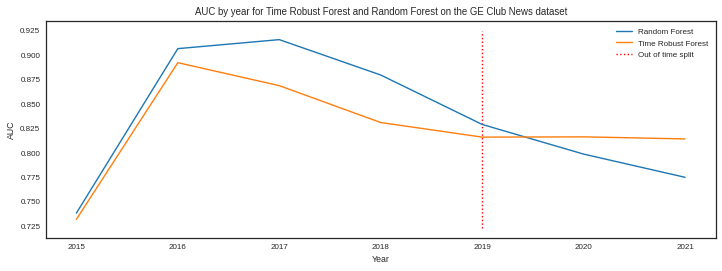

In [86]:
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Random Forest")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["challenger_prediction"])).plot(label="Time Robust Forest")
# pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_lgbm"])).plot(label="LGBM")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(4, ymin, ymax, linestyle="dotted", color="red", label="Out of time split")


plt.legend(bbox_to_anchor=(1.00, 1.0))
plt.title("AUC by year for Time Robust Forest and Random Forest on the GE Club News dataset")
plt.ylabel("AUC")
plt.xlabel("Year")
plt.show()

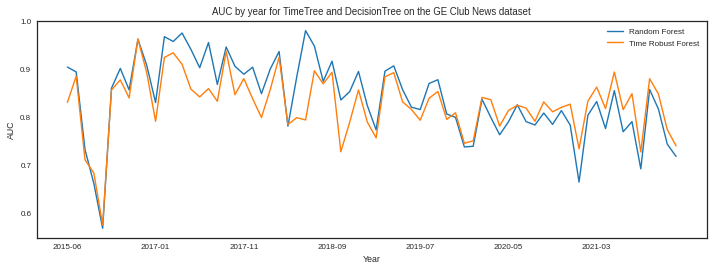

In [83]:
pd.concat([test, out_of_time]).groupby("year-month").apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Random Forest")
pd.concat([test, out_of_time]).groupby("year-month").apply(lambda x: roc_auc_score(x[target], x["challenger_prediction"])).plot(label="Time Robust Forest")
# pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_lgbm"])).plot(label="LGBM")

xmin, xmax, ymin, ymax = plt.axis()
#plt.vlines(3, ymin, ymax, linestyle="dotted", color="red", label="Out of time split")

plt.legend(bbox_to_anchor=(1.00, 1.0))
plt.title("AUC by year for Time Robust Forest and Random Forest on the GE Club News dataset")
plt.ylabel("AUC")
plt.xlabel("Year")
plt.show()

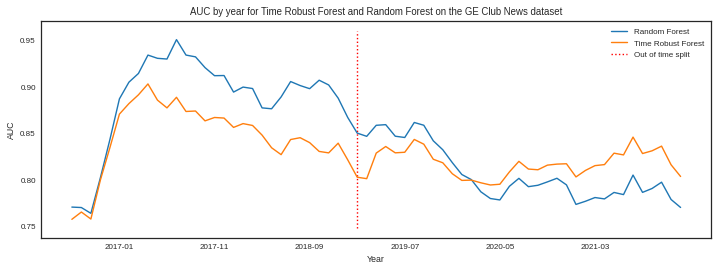

In [84]:
pd.concat([test, out_of_time]).groupby("year-month").apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).rolling(6).mean().plot(label="Random Forest")
pd.concat([test, out_of_time]).groupby("year-month").apply(lambda x: roc_auc_score(x[target], x["challenger_prediction"])).rolling(6).mean().plot(label="Time Robust Forest")
# pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_lgbm"])).plot(label="LGBM")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(35, ymin, ymax, linestyle="dotted", color="red", label="Out of time split")

plt.legend(bbox_to_anchor=(1.00, 1.0))
plt.title("AUC by year for Time Robust Forest and Random Forest on the GE Club News dataset")
plt.ylabel("AUC")
plt.xlabel("Year")
plt.show()

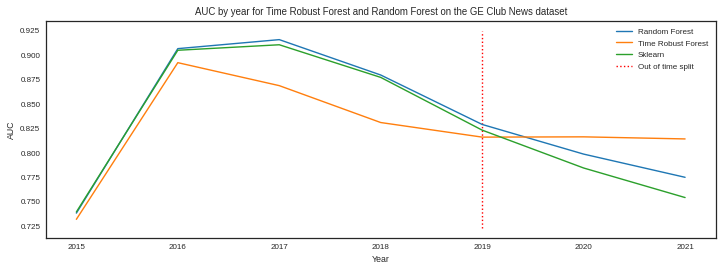

In [87]:
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Random Forest")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["challenger_prediction"])).plot(label="Time Robust Forest")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction"])).plot(label="Sklearn")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(4, ymin, ymax, linestyle="dotted", color="red", label="Out of time split")
plt.legend(bbox_to_anchor=(1.05, 1.0))

plt.legend(bbox_to_anchor=(1.00, 1.0))
plt.title("AUC by year for Time Robust Forest and Random Forest on the GE Club News dataset")
plt.ylabel("AUC")
plt.xlabel("Year")
plt.show()

## Simplified benchmark

Use similar paramters to what the challenger picked in the optimization.

In [ ]:
params_simple_benchmark = challenger_opt_param.copy()
params_simple_benchmark.pop("min_sample_periods")

params_simple_benchmark["min_sample_periods"] = train[time_column].nunique() * challenger_opt_param["min_sample_periods"]

simple_benchmark_model = TimeForestClassifier(time_column=dummy_time_column,
                                       multi=True, 
                                       **params_simple_benchmark)

simple_benchmark_model.fit(train_vectors[features + [dummy_time_column]], train[target])

In [61]:
params_simple_benchmark

{'max_depth': 10,
 'min_impurity_decrease': 0.0001,
 'n_estimators': 120,
 'period_criterion': 'max',
 'min_sample_periods': 4}

In [ ]:
train["benchmark_simple_prediction"] = simple_benchmark_model.predict_proba(train_vectors[features])[:, 1]
test["benchmark_simple_prediction"] = simple_benchmark_model.predict_proba(test_vectors[features])[:, 1]
out_of_time["benchmark_simple_prediction"] = simple_benchmark_model.predict_proba(oot_vectors[features])[:, 1]

In [93]:
print(roc_auc_score(train[target], train["benchmark_simple_prediction"]))
print(roc_auc_score(test[target], test["benchmark_simple_prediction"]))
print(roc_auc_score(out_of_time[target], out_of_time["benchmark_simple_prediction"]))

0.9158773273267589
0.868405187413732
0.8022512098413209


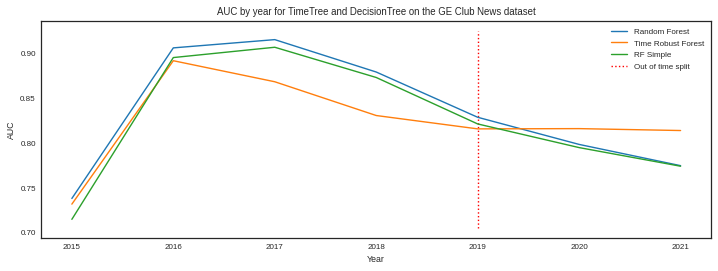

In [90]:
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Random Forest")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["challenger_prediction"])).plot(label="Time Robust Forest")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["benchmark_simple_prediction"])).plot(label="RF Simple")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(4, ymin, ymax, linestyle="dotted", color="red", label="Out of time split")

plt.legend(bbox_to_anchor=(1.00, 1.0))
plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")
plt.ylabel("AUC")
plt.xlabel("Year")
plt.show()

## Plots

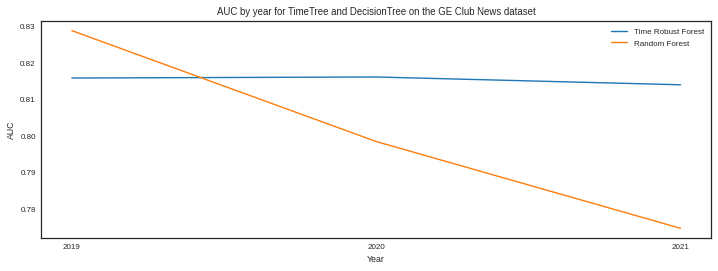

In [68]:
out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["challenger_prediction"])).plot(label="Time Robust Forest")
out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Random Forest")

plt.legend()
plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")
plt.ylabel("AUC")
plt.xlabel("Year")
plt.show()

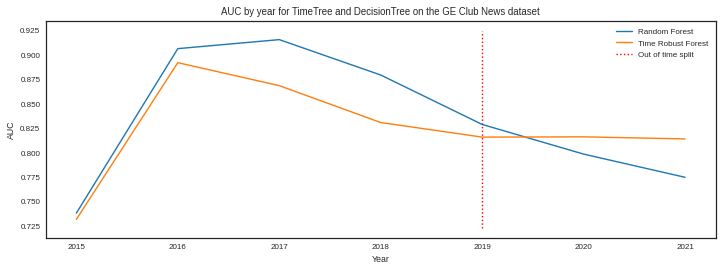

In [89]:
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Random Forest")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["challenger_prediction"])).plot(label="Time Robust Forest")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(4, ymin, ymax, linestyle="dotted", color="red", label="Out of time split")

plt.legend(bbox_to_anchor=(1.00, 1.0))
plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")
plt.ylabel("AUC")
plt.xlabel("Year")
plt.show()

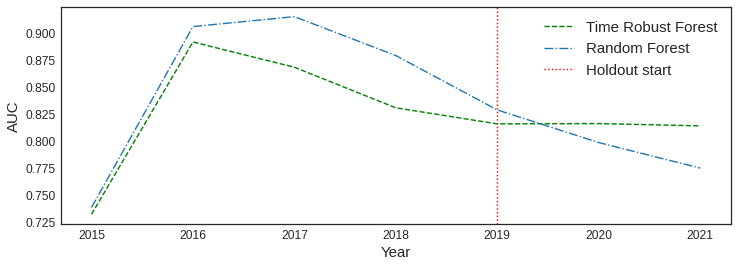

In [92]:
fig, ax = plt.subplots()

pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["challenger_prediction"])).plot(label="Time Robust Forest",
                                                                                                                        color="green", linestyle="dashed")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Random Forest", 
                                                                                                                       linestyle="-.")
# pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_lgbm"])).plot(label="LGBM", color="orange")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.vlines(4, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
#plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))

#plt.legend(bbox_to_anchor=(1.05, 1.0))
#plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")

plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
#plt.savefig("images/ge_sklearn.eps", format="eps", bbox_inches="tight")
plt.savefig("../images/genews_performance_overtime.eps", format="eps")
plt.show()

### Domain Classifier

In [124]:
train_vectors["domain"] = 1
test_vectors["domain"] = 1
oot_vectors["domain"] = 0

In [125]:
domain_data = pd.concat([train_vectors, test_vectors, oot_vectors])

In [126]:
train_domain, test_domain = train_test_split(domain_data, 
                               test_size=0.2,
                               random_state=42)



In [127]:
from pycaret.classification import *

In [130]:
clf2 = setup(train_domain[features + ["domain"]], target="domain",
             session_id=124, 
             log_experiment=False, 
             experiment_name="{}_domain".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_domain_rf = tune_model(rf,
                             optimize="AUC",
                             fold=5,
                             n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7566,0.8993,0.9529,0.5959,0.7333,0.5304,0.5804
1,0.7566,0.8963,0.9525,0.5960,0.7332,0.5304,0.5801
2,0.7586,0.8997,0.9570,0.5976,0.7357,0.5345,0.5852
3,0.7599,0.9029,0.9541,0.5992,0.7361,0.5360,0.5853
4,0.7453,0.8916,0.9562,0.5838,0.7249,0.5124,0.5672
Mean,0.7554,0.8980,0.9545,0.5945,0.7327,0.5287,0.5796
SD,0.0052,0.0038,0.0018,0.0055,0.0040,0.0085,0.0066


In [131]:
domain_model = tuned_domain_rf

In [132]:
domain_model.fit(train_domain[features], train_domain["domain"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=11, max_features=1.0,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0005, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=-1, oob_score=False, random_state=124, verbose=0,
                       warm_start=False)

In [133]:
test_domain["pred_domain"] = domain_model.predict_proba(test_domain[features])[:, 1]

In [134]:
roc_auc_score(test_domain["domain"], test_domain["pred_domain"])

0.8918694275010572